In [1]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import cmath
import math
from scipy import io, stats
from scipy.stats import mannwhitneyu, normaltest, zscore, wilcoxon, ttest_rel
from statannotations.Annotator import Annotator
import matplotlib as mpl
import matplotlib.patheffects as path_effects

cwd = os.getcwd()
sys.path.append(cwd+"/../handy_functions")

from concat_pickles import get_outputs,get_outputsSweep,print_df

fig_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/figures/manuscript'

# Figure 1: How do the decoding models work?

In [ ]:
from preprocessing_funcs import bin_spikes
from preprocessing_funcs import bin_output

data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
filename = 'vars-pa29dir4A-pre500-post300.mat'
dt = 50
data = io.loadmat(data_folder+'vars/'+filename)

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
##############################################################################################
trial = [644]

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)  

fig, ax = plt.subplots(figsize=(12, 3))

ax.eventplot(spikes[:40], colors='mediumpurple', linelengths=0.8, lineoffsets=np.arange(40));
ax.eventplot(spikes[40:], colors='forestgreen', linelengths=0.8, lineoffsets=np.arange(40,len(spikes)));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig, ax = plt.subplots(figsize=(12, 3))

poses = pos[np.isin(conditions[:,0],trial)]

ax.plot(-1*poses[:,0], label='HE', color='gray', linestyle='-', linewidth=5)
ax.plot(-1*poses[:,1], label='VE', color='gray', linestyle='--', linewidth=5)

#plt.legend()

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight')

# Figure 2: How well do the decoding models perform?

In [5]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs'

pal = sns.color_palette("Reds",20)
pal = pal[8:]
custom_palette = sns.color_palette("Reds", n_colors=4)
mtfef_pal = ['forestgreen','mediumpurple']

column_names = ['sess','repeat','outer_fold','nMT','nFEF','model','R2','rho','R2_null','rho_null','time_elapsed']
df1 = get_outputs(data_folder+'/Figure2',["m00"],column_names)
df2 = get_outputs(data_folder+'/Figure2',["m01"],column_names)
df3 = get_outputs(data_folder+'/Figure2',["m02"],column_names)
df4 = get_outputs(data_folder+'/Figure2',["m03"],column_names)
df5 = get_outputs(data_folder+'/Figure2',["m04"],column_names)
df6 = get_outputs(data_folder+'/Figure2',["m05"],column_names)
df7 = get_outputs(data_folder+'/Figure2',["m06"],column_names)

df = pd.concat([df1,df2,df3,df4,df5,df6,df7],ignore_index=False)

df.head(2)

,sess,repeat,outer_fold,nMT,nFEF,model,time_elapsed,R2_x,R2_y,rho_x,rho_y,R2N_x,R2N_y,rhoN_x,rhoN_y
0,16,0,0,24,24,0,13.653245,-0.007656,-0.008849,-0.010172,-0.025163,-0.007515,-0.005757,-0.006518,-0.002732
1,16,0,1,24,24,0,10.266712,-0.005377,-0.001944,0.000394,0.025539,-0.008061,-0.006190,-0.004085,0.001908


ValueError: x and y must be the same size

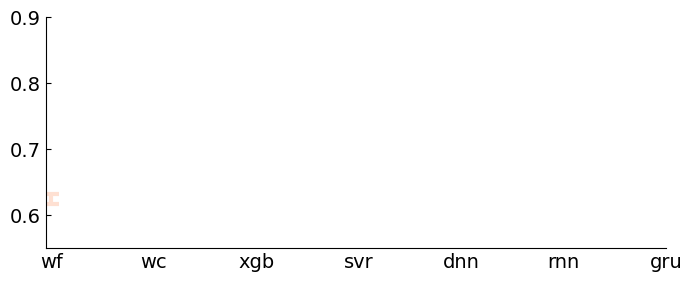

In [10]:
from scipy.stats import ttest_rel

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(8,3))

pal = sns.color_palette("Reds", n_colors=7, desat=1.0)
# pal = [(1.0, 0.0, 0.0),  # Maroon
#        (0.95, 0.0, 0.0),  # Lighter Red
#        (0.9, 0.0, 0.0),   # Slightly Dark Red
#        (0.8, 0.0, 0.0),   # Dark Red
#        (0.7, 0.0, 0.0),
#        (0.6, 0.0, 0.0),   # Darker Red
#        (0.5, 0.0, 0.0)]   # Medium Red

# pal =[(1.0, 0.0, 0.0),   # Maroon
#       (0.95, 0.0, 0.0),  # Lighter Red
#       (0.9, 0.0, 0.0),   # Slightly Dark Red
#       (0.8, 0.0, 0.0),   # Dark Red
#       (0.7, 0.0, 0.0),   # Darker Red
#       (0.6, 0.0, 0.0),   # Medium Red
#       (0.5, 0.0, 0.0),   # Slightly Lighter Red
#       (0.4, 0.0, 0.0)]    # Lightest Red

sess = 29
value = 'R2_x'
null = 'R2N_x'

wf = (df.loc[(df['model']==0) & (df['sess']==sess)][value]).values
wc = (df.loc[(df['model']==1) & (df['sess']==sess)][value]).values
xgb = (df.loc[(df['model']==2) & (df['sess']==sess)][value]).values
svr = (df.loc[(df['model']==3) & (df['sess']==sess)][value]).values
dnn = (df.loc[(df['model']==4) & (df['sess']==sess)][value]).values
rnn = (df.loc[(df['model']==5) & (df['sess']==sess)][value]).values
gru = (df.loc[(df['model']==6) & (df['sess']==sess)][value]).values
#lstm = (df.loc[(df['model']==7) & (df['sess']==sess)]['R2_x']).values

n=10
means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru)])#,np.mean(lstm)])
err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1))])#,np.std(lstm)*np.sqrt(1./n+1./(n-1))])


ind = np.arange(len(err)) #X values for plotting
for pos, y, yerr, color in zip(ind, means, err, pal): #Loop through methods and plot error bars
    ax.errorbar(pos, y, yerr, lw=3, capsize=6, capthick=3, color=color)

    #Remove x tick labels
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru'], rotation=0)

    #Remove right and top boundaries, and make ticks inward
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_yticks([0.6,0.7,0.8,0.9])
    ax.set_ylim([0.55,0.9])

    #Plot individual R2 values for each fold as an 'x'
    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(7)),(70,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn),axis=0) #Y values for plotting
    colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
    for i in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(pal[i])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.1)
    
    # Perform Wilcoxon signed-rank test and add significance asterisks
    p_value = wilcoxon(df[value][(df['model'] == pos) & (df['sess']==sess)], df[null][(df['model'] == pos) & (df['sess']==sess)])[1]
    
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'

    _, max_val = ax.get_ylim()
    max_val_per_group = max(df[value][(df['model'] == pos) & (df['sess']==sess)].max(), df[null][(df['model'] == pos) & (df['sess']==sess)].max())
    top_cap_y = max_val_per_group * 1.01

    ax.text(pos, top_cap_y, significance, ha='center', va='bottom', fontsize=16)

#fig.savefig(fig_folder+'/model_R2.png', dpi=600, bbox_inches='tight')
